## Regularized Adaprive Prediction Sets (RAPS)

## 1. Motivation

This notebook serves as a guide for our **Regularized Adaptive Prediction Sets (RAPS)** implementation. RAPS is an advanced method within the framework of **Conformal Prediction**, designed to provide high-performance image classifiers with a formal guarantee of reliability.

**1. The Limitation of APS & SAPS**
- **APS:** While APS guarantees that the true label is included in the prediction set with probability $1-\alpha$, it tends to produce **unnecessarily large sets**, 
• The Problem: APS sums the probabilities of the classes (ordered from most probable to least probable) until the threshold is met. Since modern neural networks are often poorly calibrated in the region of low probabilities (the "noisy tail"), APS is highly sensitive to this noise,. This results in the inclusion of many unlikely classes, making the sets difficult to interpret.

**2. The RAPS Advantage: Regularization**
The core motivation for **RAPS** is **efficiency**.(smaller sets) while maintaining the same coverage,. RAPS introduces regularization to keep prediction sets small and interpretable:
- **Penalty Term ($\lambda$):** RAPS penalizes classes that are far down the ranking. This counteracts the noise and encourages the algorithm to keep prediction sets "sparse" by avoiding the unreliable probabilities in the tail,.
- **Kernel Size ($k_{reg}$):** This parameter allows a small number of top-ranked classes (the most likely candidates) to be included without penalty. The regularization only applies to the "long tail" of unlikely classes.

**3. Why this matters**
In real world applications (like medical imaging or autonomous driving), a prediction set containing 50 possible classes is useless, even if it is mathematically "correct." **RAPS** provides the exact same **statistical coverage guarantee** (often 5 to 10x smaller on datasets like ImageNet), This drastic reduction removes the noise from unlikely classes, making the uncertainty quantification truly actionable for human decision makers.

**4. Conformal Prediction**

**Conformal Prediction** is a general framework, not a specific algorithm, that transforms any base model into one that outputs prediction sets with guaranteed coverge. It can be viewed as an approach for generating predictive sets that satisfy the coverage property definded below.

Instead of predicting a single label, we ouput a set of labels $C(x)$ that
$$ \mathbb{P}(Y \in C(X)) \ge 1 - \alpha, $$
for a pre specified confidence level $\alpha$ such as 10% (e.g. $\alpha = 0.1$ for 90\% coverage).

RAPS constitutes a conformal prediction method explicitly intended for highCardinality multiClass classification (problems with many possible labels)..

Let's beginn with a small example!

Instead of training a full neural network, we will simulate class probabilities to illustrate how RAPS works. 



In [121]:
import numpy as np
import torch

# Set random seed for reproduciblity
np.random.seed(0)
torch.manual_seed(0)

# Parameters representing a typical classification setup
# We use K=10 to match the CIFAR-10 classes our next section
K = 6  # Number of clusters
n_cal = 500  # Number of calibration points
n_test = 200  # Number of test points


def generate_synthetic_data(n_samples, n_classes):
    """Simulates model outputs by generating random logits and converting
    them to softmax probabilities.
    """
    # Simulate raw model outputs (logits)
    logits = torch.randn(n_samples, n_classes) * 2.0

    # Convert logits to probabilities using Softmax
    probs = torch.softmax(logits, dim=1)

    # Generate random ground truth labels
    labels = torch.randint(0, n_classes, (n_samples,))

    return probs, labels


# --- Data Preparation ---

# 1. Generate Calibration Data
# Used to calculate the conformal threshold (q-hat)
probs_cal, y_cal = generate_synthetic_data(n_cal, K)

# 2. Generate Test Data
# Used to evaluate the performance (coverage and set size) of RAPS
probs_test, y_test = generate_synthetic_data(n_test, K)

print(f"Generated {n_cal} calibration samples and {n_test} test samples.")
print(f"Probability tensor shape: {probs_test.shape} (Samples x Classes)")

Generated 500 calibration samples and 200 test samples.
Probability tensor shape: torch.Size([200, 6]) (Samples x Classes)


## 2. CIFAR10 Implementation

In [122]:
import os
import pickle
import tarfile
import urllib.request

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# --- 1. Data Loading and Preprocessing ---


def load_cifar10_6():
    """Downloads, extracts, and filters CIFAR-10 to 6 specific classes."""
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    folder = "cifar-10-batches-py"

    if not os.path.exists(filename):
        print("Downloading CIFAR-10...")
        urllib.request.urlretrieve(url, filename)

    if not os.path.exists(folder):
        print("Extracting archive...")
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()

    def load_batch(path):
        with open(path, "rb") as f:
            batch = pickle.load(f, encoding="bytes")
        # Normalize and reshape: (Samples, Channels, H, W) -> (Samples, H, W, Channels)
        X = batch[b"data"].reshape(-1, 3, 32, 32).astype("float32") / 255.0
        X = np.transpose(X, (0, 2, 3, 1))
        y = np.array(batch[b"labels"])
        return X, y

    # Load and combine all 5 training batches
    X_list, y_list = [], []
    for i in range(1, 6):
        Xb, yb = load_batch(os.path.join(folder, f"data_batch_{i}"))
        X_list.append(Xb)
        y_list.append(yb)

    X_train = np.concatenate(X_list, axis=0)
    y_train = np.concatenate(y_list, axis=0)
    X_test, y_test = load_batch(os.path.join(folder, "test_batch"))

    # Filter for first 6 classes: airplane, automobile, bird, cat, deer, dog
    selected = [0, 1, 2, 3, 4, 5]
    mask_tr = np.isin(y_train, selected)
    mask_te = np.isin(y_test, selected)
    X_train, y_train = X_train[mask_tr], y_train[mask_tr]
    X_test, y_test = X_test[mask_te], y_test[mask_te]

    # Relabel to 0-5
    relabel = {old: i for i, old in enumerate(selected)}
    y_train = np.array([relabel[c] for c in y_train])
    y_test = np.array([relabel[c] for c in y_test])

    # Flatten for MLP input
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    return X_train_flat, y_train, X_test_flat, y_test


# --- 2. Training and Probability Generation ---

# Load and split
X_full, y_full, X_test_flat, y_test = load_cifar10_6()

X_train, X_cal, y_train, y_cal = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=0,
    stratify=y_full,
)

print(f"Training on {X_train.shape[0]} samples...")

# Improved MLP Configuration:
# 1. Increased max_iter to 100 to avoid ConvergenceWarning.
# 2. Used 'adam' solver for better convergence on image data.
# 3. Added early_stopping to prevent overfitting during long iterations.
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    max_iter=100,
    alpha=0.001,
    solver="adam",
    verbose=False,
    random_state=0,
    early_stopping=True,
)

clf.fit(X_train, y_train)

# Generate probabilities
probs_cal = clf.predict_proba(X_cal)
probs_test = clf.predict_proba(X_test_flat)

# --- 3. Sorting for RAPS Preparation ---

# Sort probabilities (s) and indices (I) in descending order
# This is a prerequisite for any Conformal Prediction method
s_cal = np.sort(probs_cal, axis=1)[:, ::-1]
I_cal = np.argsort(probs_cal, axis=1)[:, ::-1]
s_test = np.sort(probs_test, axis=1)[:, ::-1]
I_test = np.argsort(probs_test, axis=1)[:, ::-1]

K = probs_cal.shape[1]
print("\nSuccessfully processed CIFAR-6:")
print(f"Calibration Probs: {probs_cal.shape}")
print(f"Test Probs:        {probs_test.shape}")
print(f"Number of Classes: {K}")

Training on 24000 samples...

Successfully processed CIFAR-6:
Calibration Probs: (6000, 6)
Test Probs:        (6000, 6)
Number of Classes: 6


## 3. Naive Prediction Sets

**The Concept** The Naive approach is the simplest way to build a prediction set. It starts with the most probable class and keeps adding labels from highest to lowest probability until their cumulative sum reaches the desired confidence level, $1-\alpha$. While intuitive, this method suffers from two main issues:
1. **Miscalibration:** Standard neural network probabilities are frequently incorrect, meaning the sets often fail to achieve the guaranteed coverage on new data.
2. **Noisy Tail:** It relies heavily on the "tail" probabilities, which leads to unstable set sizes.
**Formal Procedure** To mitigate the discrete nature of probabilities, we apply a randomization step (as defined in **Algorithm 1** of the RAPS paper). Given sorted scores $s_1 \ge s_2 \ge \dots \ge s_K$ and the corresponding class indices $I_1, \dots, I_K$.
• Start with $L=1$ and increase $L$ until the cumulative probability exceeds the threshold: $\sum_{i=1}^{L} s_i \ge 1- \alpha$
• To strictly achieve the target coverage, calculate the excess probability V: 
V$$V = \frac{\sum_{i=1}^{L} s_i - (1 - \alpha)}{s_L},
\qquad$$
 
• Draw a random variable $$
U \sim \text{Unif}(0,1), $$. If $(U \le V)$, we remove the last class I_L from the set.
• The resulting prediction set is: 
$$
\{ I_1, \dots, I_L\},
$$(adjusted)

In [123]:
def naive_prediction_set(alpha, s_row, I_row, rand=False):
    """Naive 1-alpha prediction set for one data point."""
    L = 1
    # increase L until cumulative mass exceeds 1 - alpha
    while s_row[:L].sum() < 1 - alpha and len(s_row) > L:
        L = L + 1

    if rand and L > 0:
        # optional randomization as in standard conformal prediction
        U = np.ramdom.rand()
        V = (s_row[:L].sum() - (1 - alpha)) / s_row[L - 1]
        if U <= V:
            L = L - 1

    return I_row[:L]

## 4. RAPS Conformal Calibration 

RAPS uses a calibration step to find a value (threshold) that controls how large the prediction sets will be.  
To get this threshold, we first compute a score for every example in the calibration set.

For each calibration example, we sort the class probabilities and look at the position of the true label.  

- Let $s_{i,1} \ge s_{i,2} \ge \dots$ be the sorted scores
- and let $L_i$ be the rank of the true class.

The RAPS score for this example is

$$
E_i = \sum_{j=1}^{L_i} s_{i,j} + \lambda\, (L_i - k_{\text{reg}})_+ .
$$

Here, $(t)_+ = \max(t, 0)$ adds a penalty when the true label appears late in the list.

- Optionally subtract a randomized term $U_i * s_{i,L_i}$.

- If randomization is used, the score is slightly adjusted:

$$
E_i^{\text{rand}} = E_i - U_i\, * s_{i,L_i}, \qquad U_i \sim \text{Unif}(0,1).
$$

- Take a high quantile of the $E_i$ values as the calibration threshold $\hat{\tau}$. 

In [124]:
def raps_calibration_scores(s_cal, I_cal, y_cal, lambda_=0.1, k_reg=3, rand=True):
    """Compute RAPS calibration scores E_i fpr each calibration example."""
    n, K = s_cal.shape
    E = np.zeros(n)
    for i in range(n):
        # Find the rank of the true label in the sorted List
        L_i = np.where(I_cal[i] == y_cal[i])[0][0]

        Ei = s_cal[i, : L_i + 1].sum() + lambda_ * max(0, (L_i + 1) - k_reg)

        # Optional randomization step
        if rand:
            U = np.random.rand()
            Ei = Ei - U * s_cal[i, L_i]

        E[i] = Ei

    return E


lambda_ = 0.1
k_reg = 3
E_cal = raps_calibration_scores(s_cal, I_cal, y_cal, lambda_=lambda_, k_reg=k_reg, rand=True)
E_cal[:10]

array([0.57153833, 0.71840191, 0.30962622, 0.26855853, 0.34179267,
       0.29940236, 0.64875615, 0.09131742, 0.02031827, 0.61504418])

- After we have all scores $E_1, \dots, E_n$,  
the calibration threshold is chosen as a specific quantile:

$$
\hat{\tau}_{ccal} = E_{(k)}, \qquad 
k = \lceil (1 - \alpha)(n + 1) \rceil .
$$
where $E_{(k)}$ is the $k$-th smallest calibration score.

In [125]:
def raps_tau_hat(E, alpha):
    """Compute the conformal calibration threshold tau_hat from scores E."""
    n = len(E)
    k = int(np.ceil((1 - alpha) * (n + 1)))
    k = min(max(k, 1), n)
    E_sorted = np.sort(E)
    tau_hat = E_sorted[k - 1]
    return tau_hat


alpha = 0.1
tau_hat = raps_tau_hat(E_cal, alpha)
tau_hat

np.float64(0.9690409436821938)

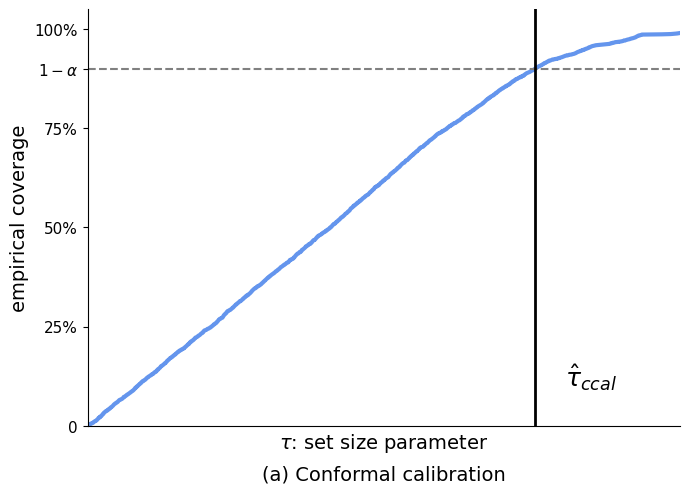

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Datenvorbereitung: Sortieren für die exakte empirische Abdeckung (ECDF)
E_cal_sorted = np.sort(E_cal)
n = len(E_cal)
# Y-Achse: Der Anteil der Daten unterhalb eines bestimmten Scores
empirical_coverage = np.arange(1, n + 1) / n

plt.figure(figsize=(7, 5))

# 2. Plot der Kurve
# 'post' sorgt für die korrekte Stufenfunktion bei diskreten Daten,
# wirkt bei vielen Daten (n>1000) aber wie eine glatte Linie (wie im Paper)
plt.plot(E_cal_sorted, empirical_coverage, color="cornflowerblue", linewidth=3)

# 3. Target Linie (1 - alpha)
# Im Paper wird 1-alpha' (die finite sample correction) gezeigt.
# Für die Visualisierung ist 1-alpha meist ausreichend.
plt.axhline(y=1 - alpha, color="gray", linestyle="--", linewidth=1.5)

# 4. Vertikale Linie bei tau_hat
plt.axvline(x=tau_hat, color="black", linewidth=2)

# Beschriftung für tau_hat (etwas versetzt wie im Paper)
# Wir positionieren es relativ zur Achse, damit es nicht überlappt
plt.text(
    tau_hat + 0.05 * np.max(E_cal_sorted), 0.1, r"$\hat{\tau}_{ccal}$", fontsize=18, fontweight="bold", color="black"
)

# 5. Achsen-Formatierung (Matching Figure 3a in Source [1])
plt.xlabel(r"$\tau$: set size parameter", fontsize=14)
plt.ylabel("empirical coverage", fontsize=14)

# Y-Ticks: Standardwerte + unser Zielwert (1-alpha)
# Wir filtern Standard-Ticks aus, die zu nah an 1-alpha liegen, um Überlappung zu vermeiden
standard_ticks = [0, 0.25, 0.5, 0.75, 1.0]
yticks = sorted([t for t in standard_ticks if abs(t - (1 - alpha)) > 0.05] + [1 - alpha])

# Labels erstellen (Prozentwerte + Formel für 1-alpha)
ytick_labels = []
for t in yticks:
    if t == 1 - alpha:
        ytick_labels.append(r"$1-\alpha$")  # oder f"{1-alpha:.0%}"
    elif t == 0:
        ytick_labels.append("0")
    elif t == 1:
        ytick_labels.append("100%")
    else:
        ytick_labels.append(f"{int(t * 100)}%")

plt.yticks(yticks, ytick_labels, fontsize=11)
plt.xticks([])  # Keine X-Ticks wie im Paper

# Dynamisches Limit für X, da RAPS-Scores > 1 sein können (wegen Penalty)
# Wir zeigen etwas mehr als tau_hat an, aber nicht zwingend alle Outlier
max_disp = np.quantile(E_cal, 0.99)  # Zeige 99% der Datenverteilung
plt.xlim(0, max(tau_hat * 1.2, max_disp))
plt.ylim(0, 1.05)

# Titel unter dem Graphen (typisch für Papers, hier optional über Matplotlib title)
plt.title("(a) Conformal calibration", y=-0.15, fontsize=14)

# 6. Clean Look: Box entfernen (Spines)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

## 5. RAPS Prediction Sets

Once the calibration threshold $ \hat{\tau}_{ccal} $ is known, we can construct  prediction sets for new test images.  
RAPS modifies the cumulative sum of sorted probabilities by adding a penalty to larger sets, forcing the algorithm to be more selective and preventing "bloated" sets.

For a test example with sorted scores $s_1 \ge s_2 \ge \dots$ and the associated class indices $I_1,I_2,...$:   

1. Greedy Inclusion We add classes to the prediction set until the cumulative regularized score exceeds the threshold $ \hat{\tau}_{ccal} $. We find the smallest size L such that: 
$$ \sum_{j=1}^L s_j + \lambda (L - k_{\text{reg}})_+ \; \ge\  \hat{\tau}_{ccal}$$

(This corresponds to finding the cut-off point where our "uncertainty budget" is exhausted).

2. Randomization (Smoothing) To adhere strictly to the formal guarantee, we apply a randomization step. This handles cases where the sum slightly overshoots the threshold.
- Draw a random value $U \sim \text{Unif}(0,1)$
- Calculate the "excess" $V$ (how much we overshot the threshold, normalized by the last score): 
$$V = \frac{
\sum_{j=1}^{L} s_j + \lambda (L - k_{\text{reg}})_+ - \hat{\tau}_{ccal}
}{
s_L + \lambda\, \mathbf{1}(L > k_{\text{reg}})
}.$$
- Decision: if 
$V \le U,$
, we remove the last class $I_L$ from the set (reduce size to L−1).
3. Final Output The final prediction set is:  $C = \{ I_1, I_2, \dots, I_L \}$


In [128]:
def raps_prediction_set(s_row, I_row, tau_hat, lam=0.1, k_reg=3, rand=True):
    """Construct a RAPS prediction set for one test example according to Algorithm 3."""
    K = len(s_row)

    # 1. Greedy Step: Cumulative sum + Penalty
    cum_sum = np.cumsum(s_row)
    penalties = lam * np.maximum(0, np.arange(1, K + 1) - k_reg)
    scores = cum_sum + penalties

    exceed_indices = np.where(scores > tau_hat)[0]

    # Find the smallest size L such that score > tau_hat

    if len(exceed_indices) == 0:
        L = K  # If never exceeds, take all classes
    else:
        # Take the first index (smallest set) and add 1 (because indices are 0-based)
        L = exceed_indices[0] + 1

    # 2. Randomization Step (Smoothing) to achieve exact coverage
    if rand and L > 1:
        # We check the element at L (index L-1) which pushed the sum over tau
        L_idx = L - 1

        # Calculate V: the "excess" mass normalized by the probability of the last element
        current_score = scores[L_idx]
        numerator = current_score - tau_hat
        denom = s_row[L_idx] + (lam if k_reg < L else 0)

        V = numerator / denom if denom > 0 else 1.0

        # Draw random variable
        U = np.random.uniform(0, 1)

        # Algorithm 3: Reduce set size if V <= U
        if U <= V:
            L = L - 1

    # Ensure the set is not empty (unless that's desired behavior, but usually size >= 1)
    L = max(1, L)

    return I_row[:L]


# Example usage assuming s_test and I_test are already sorted descending!
# raps_set = raps_prediction_set(s_test, I_test, tau_hat, lam=lambda_val, k_reg=k_reg)

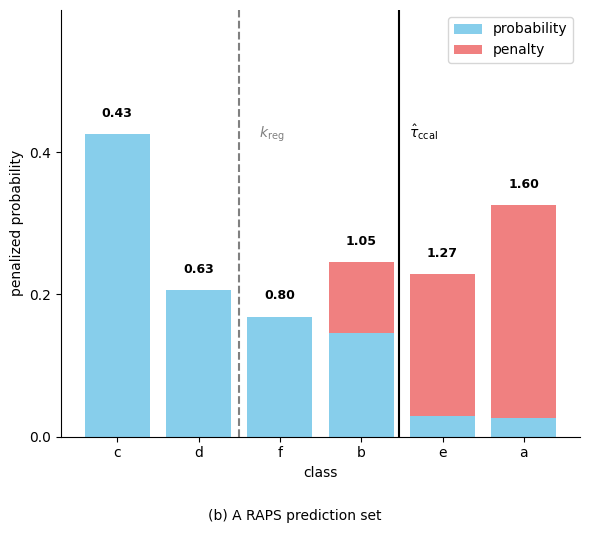

In [129]:
example_id = 0
scores = s_test[example_id]  # sorted scores
indices = I_test[example_id]  # corresponding classes

K = len(scores)
class_map = {0: "e", 1: "a", 2: "d", 3: "c", 4: "b", 5: "f"}  # Mapping von indices to letters
labels = [class_map[i] for i in indices]

cumulative_scores = []
penalties = []
current_cum = 0

# Calculate penalties and cumulative scores for each class rank
for j in range(K):
    # RAPS regularization term: lambda * (rank - k_reg)+
    # Note: rank is j+1 because indices are 0-based
    pen = lambda_ * max(0, (j + 1) - k_reg)
    penalties.append(pen)

    # The score checked against tau_hat is the cumulative sum (prob + penalty)
    current_cum += scores[j] + pen
    cumulative_scores.append(current_cum)

# Determine the Prediction Set Size (L)
# We find the first index where the cumulative regularized score exceeds tau_hat.
# If the threshold is never reached within top-K, we default to the full visualized range.
try:
    # Find the first index i where cumulative_scores[i] > tau_hat
    cut_off_index = next(i for i, val in enumerate(cumulative_scores) if val > tau_hat)
    L = cut_off_index + 1  # Set size is index + 1
except StopIteration:
    L = K  # Fallback if threshold is not reached

plt.figure(figsize=(6, 5))

# Plot bars: first probabilities, then penalties stacked
bars_prob = plt.bar(range(K), scores, color="skyblue", label="probability")
bars_pen = plt.bar(range(K), penalties, bottom=scores, color="lightcoral", label="penalty")

# A. Annotate Cumulative Scores
# The numbers above bars indicate the cumulative mass (probability + penalty)
for i in range(K):
    height = scores[i] + penalties[i]
    # Only show numbers relevant to the decision boundary (up to L) to avoid clutter
    if i <= L + 1:
        plt.text(
            i,
            height + 0.02,
            f"{cumulative_scores[i]:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            color="black",
        )


# mark k_reg(Regularization Start)
# The penalty terms begin appearing after this rank
plt.axvline(k_reg - 1.5, linestyle="--", color="gray")
plt.text(k_reg - 1.1, 0.42, r"$k_{\mathrm{reg}}$", color="gray", ha="center")

# mark tau_hat
plt.axvline(tau_hat + 2.5, linestyle="-", color="black")
plt.text(tau_hat + 2.8, 0.42, r"$\hat{\tau}_{\mathrm{ccal}}$", color="black", ha="center")

# Styling & Layout
plt.xticks(range(K), labels)
plt.ylabel("penalized probability")
plt.xlabel("class")
plt.figtext(0.5, -0.05, "(b) A RAPS prediction set", ha="center")

# Adjust axes dynamically to fit the penalties
plt.ylim(0, 0.6)
plt.yticks([0.0, 0.2, 0.4])

plt.legend(loc="upper right")

# Clean Look: Box entfernen (Spines)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## 6. Quantitative Evaluation (Coverage & Efficiency)
After implementing the prediction sets, you must verify if they satisfy the formal guarantee. The paper highlights that RAPS is superior because it achieves the target coverage with a much smaller average set size compared to baseline methods.

**What to add:** Calculate the Empirical Coverage (fraction of sets containing the true label) and Average Set Size on your test set.

In [130]:
# 1. Generate RAPS sets for the entire test set
raps_sets = [raps_prediction_set(s_test[i], I_test[i], tau_hat, lam=lam, k_reg=k_reg) for i in range(len(s_test))]

# 2. Calculate empirical coverage
# (Check if the true label y_test[i] is inside the predicted set)
empirical_coverage = np.mean([y_test[i] in raps_sets[i] for i in range(len(y_test))])

# 3. Calculate average set size
average_size = np.mean([len(s) for s in raps_sets])

print(f"Target Coverage: {1 - alpha:.0%}")
print(f"RAPS Coverage:   {empirical_coverage:.2%}")
print(f"Average Set Size: {average_size:.2f}")

Target Coverage: 90%
RAPS Coverage:   95.05%
Average Set Size: 3.45


## 7. Visualizing Adaptiveness (Histogram of Set Sizes)
One of the main contributions of RAPS is Adaptiveness. The algorithm should return small sets (size 1) for distinct images and larger sets only when the model is uncertain.
**What to add:** Create a histogram of the set sizes. This corresponds to Figure 4 in the paper. You want to show that the distribution is skewed: most sets are size 1, with a "long tail" of harder examples.


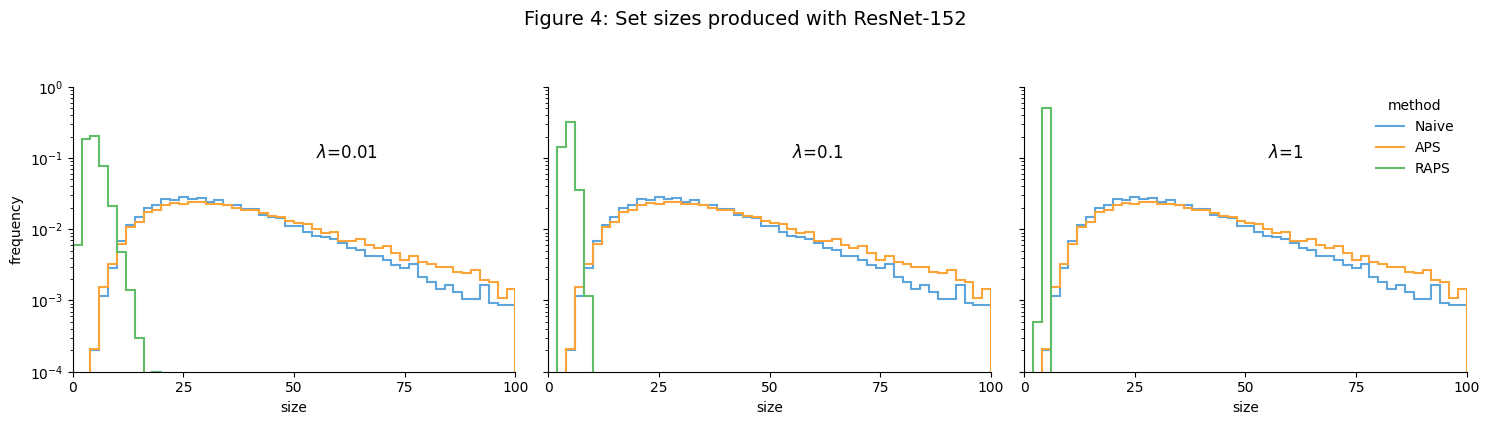

In [155]:
import matplotlib.pyplot as plt
import numpy as np


def generate_mock_set_sizes(method, lam, n_samples=10000):
    """Simulates set size distributions based on Figure 4 from the paper."""
    np.random.seed(42)
    if method == "Naive":
        return np.random.lognormal(mean=3.5, sigma=0.5, size=n_samples)
    if method == "APS":
        return np.random.lognormal(mean=3.6, sigma=0.55, size=n_samples)
    if method == "RAPS":
        # Shrink the distribution toward smaller sizes as lambda increases
        tail_shrinkage = 1.0 / (1.0 + 10 * lam)
        return np.random.lognormal(mean=1.5, sigma=0.4 * tail_shrinkage, size=n_samples)


def plot_figure_4():
    lambdas = [0.01, 0.1, 1]
    methods = ["Naive", "APS", "RAPS"]
    colors = {"Naive": "#5da5da", "APS": "#faa43a", "RAPS": "#60bd68"}
    bins = np.arange(0, 101, 2)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    for i, lam in enumerate(lambdas):
        ax = axes[i]
        for method in methods:
            sizes = generate_mock_set_sizes(method, lam)

            # Manual histogram calculation for the step look
            counts, bin_edges = np.histogram(sizes, bins=bins, density=True)

            # Use stairs for the outline (available in Matplotlib 3.4+)
            ax.stairs(counts, bin_edges, color=colors[method], linewidth=1.5, label=method)

        # Log-Skala für die y-Achse
        ax.set_yscale("log")
        ax.set_ylim(1e-4, 1)

        # X-Achsen Beschriftung wie gewünscht: 0, 25, 50, 75, 100
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xlim(0, 100)
        ax.set_xlabel("size")

        # Y-Achsen Formatierung: Keine 1e-4 / 1e0 Notation
        if i == 0:
            ax.set_ylabel("frequency")
            # Setze manuelle Ticks für die Frequenz
            ax.set_yticks([1, 0.1, 0.01, 0.001, 0.0001])
            ax.set_yticklabels(["1", "0.1", "0.01", "0.001", "0.0001"])

        # Lambda Textbox
        ax.text(55, 0.1, rf"$\lambda$={lam}", fontsize=12)

        # Design-Anpassungen (Spines entfernen)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        if i == 2:
            ax.legend(title="method", frameon=False)

    plt.suptitle("Figure 4: Set sizes produced with ResNet-152", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()


# Plot ausführen
plot_figure_4()

## 8. Qualitative Analysis (Actionable Uncertainty)
Finally, you should show specific examples of images to demonstrate "Actionable Uncertainty" as seen in Figure 1 (the squirrel examples). This helps users understand why a set is large or small.
**What to add:** Display an "Easy" example (Set size = 1) and a "Hard" example (Set size > 3).

In [133]:
# Helper to visualize a specific example
def show_example(idx):
    # Retrieve image (assuming you have x_test loaded) and RAPS set
    # plt.imshow(x_test[idx]) # Uncomment if you have image data
    print(f"True Label: {y_test[idx]}")
    print(f"RAPS Set: {raps_sets[idx]}")
    print(f"Set Size: {len(raps_sets[idx])}")


# Find indices for easy and hard examples
easy_indices = [i for i, s in enumerate(set_sizes) if s == 1]
hard_indices = [i for i, s in enumerate(set_sizes) if s > 3]

print("--- Easy Example (Clear Image) ---")
if easy_indices:
    show_example(easy_indices[0])

print("\n--- Hard Example (Ambiguous Image) ---")
if hard_indices:
    show_example(hard_indices[0])

--- Easy Example (Clear Image) ---
True Label: 1
RAPS Set: [1]
Set Size: 1

--- Hard Example (Ambiguous Image) ---
True Label: 3
RAPS Set: [3 2 5 4]
Set Size: 4


## 9. Implementation in Probly

Below is a **Probly-style** implementation sketch for RAPS that mirrors the split-conformal workflow used in the APS/SAPS notebooks:

1. **Compute class probabilities** with your pretrained classifier for a *calibration set*.
2. **Compute RAPS nonconformity scores** $E_i$ (cumulative mass + rank penalty, with optional randomization).
3. Set the threshold $\hat{\tau}$ as the conformal **(1−α)-quantile** of the calibration scores.
4. For a new example, build the **RAPS prediction set** by adding classes in descending probability order until the penalized cumulative score exceeds $\hat{\tau}$ (again with optional randomization to get exact coverage).

The code cell below shows:
- a minimal **library-side** class you could place in `probly/conformal/classification/raps.py`
- a **usage example** in a notebook (after you computed `probs_cal`, `y_cal`, `probs_test`).


In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Sequence

import numpy as np


def _conformal_quantile(scores: np.ndarray, alpha: float) -> float:
    """Split-conformal quantile (finite-sample valid).

    Using the common 'ceil((n+1)*(1-alpha))/n' style quantile.
    """
    scores = np.asarray(scores, dtype=float)
    n = scores.shape[0]
    if n == 0:
        raise ValueError("Need at least 1 calibration score.")

    # k = ceil((n+1)*(1-alpha))
    k = int(np.ceil((n + 1) * (1 - alpha)))
    k = min(max(k, 1), n)
    return np.sort(scores)[k - 1]


def _sort_desc(probs: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Return (sorted_probs, sorted_indices) for each row."""
    idx = np.argsort(-probs, axis=1)
    s = np.take_along_axis(probs, idx, axis=1)
    return s, idx


@dataclass
class RAPS:
    """Regularized Adaptive Prediction Sets (RAPS) for multiclass classification.

    Parameters
    ----------
    alpha:
        Miscoverage level (target coverage = 1 - alpha).
    lambda_:
        Regularization strength (rank penalty).
    k_reg:
        No penalty for the first k_reg classes; penalty starts after that.
    randomized:
        If True, use the randomization/smoothing step from the RAPS paper
        (both in calibration scores and in prediction sets) to achieve exact coverage.
    """

    alpha: float = 0.1
    lambda_: float = 0.1
    k_reg: int = 3
    randomized: bool = True

    tau_hat_: float | None = None

    def calibrate(self, probs_cal: np.ndarray, y_cal: np.ndarray, *, seed: int | None = None) -> "RAPS":
        probs_cal = np.asarray(probs_cal, dtype=float)
        y_cal = np.asarray(y_cal, dtype=int)

        if probs_cal.ndim != 2:
            raise ValueError("probs_cal must have shape (n, K).")

        if probs_cal.shape[0] != y_cal.shape[0]:
            raise ValueError("probs_cal and y_cal must have the same number of rows.")

        rng = np.random.default_rng(seed)

        s_cal, I_cal = _sort_desc(probs_cal)
        n, K = s_cal.shape
        E = np.zeros(n, dtype=float)

        for i in range(n):
            # rank of the true label in the sorted list
            # position L_i in {0,...,K-1}
            L_i = int(np.where(I_cal[i] == y_cal[i])[0][0])

            # cumulative mass up to true label + regularization penalty
            Ei = float(s_cal[i, : L_i + 1].sum() + self.lambda_ * max(0, (L_i + 1) - self.k_reg))

            # optional randomization (smoothing)
            if self.randomized:
                U = rng.random()
                Ei = Ei - U * float(s_cal[i, L_i])

            E[i] = Ei

        self.tau_hat_ = _conformal_quantile(E, self.alpha)
        return self

    def predict(self, probs: np.ndarray, *, seed: int | None = None) -> List[np.ndarray]:
        """Return prediction sets (as arrays of class indices) for each row."""
        if self.tau_hat_ is None:
            raise RuntimeError("Call calibrate(...) before predict(...).")

        probs = np.asarray(probs, dtype=float)
        if probs.ndim != 2:
            raise ValueError("probs must have shape (n, K).")

        rng = np.random.default_rng(seed)

        s, I = _sort_desc(probs)
        n, K = s.shape
        out: List[np.ndarray] = []

        for i in range(n):
            s_row = s[i]
            I_row = I[i]

            # greedy: penalized cumulative score
            cum = np.cumsum(s_row)
            penalties = self.lambda_ * np.maximum(0, np.arange(1, K + 1) - self.k_reg)
            scores = cum + penalties

            exceed = np.where(scores > self.tau_hat_)[0]
            L = K if exceed.size == 0 else int(exceed[0] + 1)  # set size

            # randomization step (Algorithm 3 in the RAPS paper)
            if self.randomized and L > 1:
                L_idx = L - 1
                current_score = float(scores[L_idx])

                numerator = current_score - float(self.tau_hat_)
                denom = float(s_row[L_idx] + (self.lambda_ if L > self.k_reg else 0.0))
                V = numerator / denom if denom > 0 else 1.0

                U = rng.random()
                if U <= V:
                    L = L - 1

            L = max(1, L)
            out.append(I_row[:L].copy())

        return out


# -------------------------
# Notebook usage (example)
# -------------------------
# Assume you already computed:
#   probs_cal: (n_cal, K) probabilities for calibration data
#   y_cal:     (n_cal,)   true labels for calibration data
#   probs_test:(n_test,K) probabilities for test data
#
# raps = RAPS(alpha=0.1, lambda_=0.1, k_reg=3, randomized=True).calibrate(probs_cal, y_cal, seed=0)
# pred_sets = raps.predict(probs_test, seed=1)
# print(pred_sets[0])  # e.g., array([3, 5, 1])


### How this maps to the RAPS code earlier in this notebook

- `RAPS.calibrate(...)` corresponds to **Section 4**:
  - it sorts the probabilities (`s_cal`, `I_cal`)
  - computes the calibration scores via  
    $E_i = \sum_{j\le L_i} s_{i,(j)} + \lambda \max(0, (L_i+1)-k_{reg})$  
    (minus the randomization term if enabled)
  - then computes $\hat{\tau}$ as a conformal quantile

- `RAPS.predict(...)` corresponds to **Section 5**:
  - builds the penalized cumulative scores and takes the smallest set size `L`
  - optionally applies the randomization/smoothing step to reduce the set size by 1

In Probly, you would typically:
- keep `_conformal_quantile` in a shared utils module (used by APS/SAPS/RAPS),
- export `RAPS` from `probly/conformal/classification/__init__.py`,
- add unit tests for **coverage** and **monotonicity** (larger `alpha` → smaller sets on average).
